## Regret Analysis of OFL - \<Performance Experiments\>

### 1. Environment Setting

In [2]:
import  torch
import  numpy as np
import  matplotlib.pyplot as plt
from    keras import datasets
import  import_ipynb

from RegretBound import opt_param
from data import MNIST_data, Air_data, Syn_data
from model import OFL_Model

K = 1000        # Number of clients
D = 34826       # number of parameters
P = 0.01        # Com. overhead reduction rate from FedOGD
L = 10          # Local training time (Batch Size)

s, _, b, p = opt_param(P, D, show_result=False)

### 2. Experiment Setting

In [5]:
### Running Time (~2min, iMac 27(2019)) ###

#MNIST
x_train, y_train = MNIST_data()
task = 'clf'

#Air
# x_train, y_train = Air_data()
# task = 'reg'

#Synthetic data
# x_train, y_train = pull_Syn_data('Syn', 0)
# task = ''

Model_list = []

Model_list.append(OFL_Model('FedOGD', task, K, [False, 0, 0, 0], 1, 1))
Model_list.append(OFL_Model('OFedAvg', task, K, [False, 0, 0, 0], P, L))
Model_list.append(OFL_Model('OFedPQ', task, K, [True, s, b, p], P, 1))
Model_list.append(OFL_Model('OFedPAQ', task, K, [True, s, b, p], P, L))

### 3. Training

In [6]:
for model in Model_list:
    for iter in range(10):
        for i in range(60):
            model.train(x_train[K*i : K*(i+1)], y_train[K*i : K*(i+1)], (i+1) % model.L)
        print(iter, end =',')

result_list = []
for model in Model_list:
    result_list.append(model.pull_result())

InvalidArgumentError: Incompatible shapes: [3,3,1,32] vs. [3,3,32,64] [Op:AddV2]

### 3. Save Result

In [7]:
import pickle

code = input("Code: ")

for i, model in enumerate(Model_list):
    name = model.name
    with open(f"./result/{task}_{name}_{code}.pkl","wb") as f:
        pickle.dump(result_list[i], f)

### 4. Plot Result

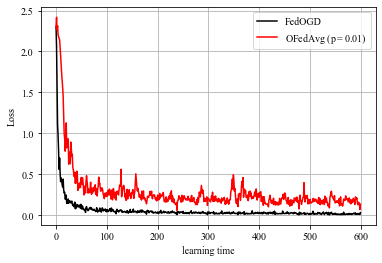

In [21]:
code = input('Code:')

l1 = list(range(len(result_list[0])))
l2 = list(range(len(result_list[1])))
l3 = list(range(len(result_list[2])))
l4 = list(range(len(result_list[3])))

plt.plot(l1, result_list[0], 'black', label=r'FedOGD')
plt.plot(l2, result_list[1], 'red', label=r'OFedAvg ($\mathdefault{p=0.01}$)')
plt.plot(l3, result_list[2], 'blue', label=r'OFedPQ ($\mathdefault{p=0.01}$)')
plt.plot(l4, result_list[3], 'green', label=r'OFedPAQ ($\mathdefault{p=0.01}$)')

plt.xlabel('learning time')

if task == 'clf':
    plt.ylabel('Accuracy')
elif task == 'reg':
    plt.ylabel('Loss')

plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()

plt.savefig(f'./Figures/{task}_{code}.png', dpi=200, facecolor="white")
plt.show()